In [1]:
%config InlineBackend.figure_formats = ['svg']
import quimb.tensor as qtn
from quimb.experimental.cluster_update.cxu import ClusterUpdateGen

Define the geometry and Hamiltonian:

In [2]:
L = 4
edges = qtn.edges_2d_square(L, L)
ham = qtn.ham_2d_heis(L, L)

Customize how we compute the energy:

In [3]:
def compute_energy(psi, gauges, method="boundary", max_bond=None):
    psi = psi.copy()

    if method == "cluster":
        gauges = gauges.copy()
        psi.gauge_all_simple_(100, 1e-6, gauges=gauges)
        return psi.compute_local_expectation_cluster(
            ham.terms,
            max_distance=0,
            normalized=True,
            gauges=gauges,
            optimize="auto-hq",
        ) / psi.nsites

    psi = psi.copy()
    if gauges is not None:
        psi.gauge_simple_insert(gauges)

    if method == "exact" or psi.nsites <= 20:
        psi.contract_(all, optimize="auto-hq")
        return psi.compute_local_expectation_exact(ham.terms) / psi.nsites

    if method == "boundary":

        if max_bond is None:
            max_bond = max(16, psi.max_bond()**2)

        return psi.compute_local_expectation(
            ham.terms,
            max_bond=max(16, psi.max_bond()**2),
            equalize_norms=1.0,
            normalized=True,
            layer_tags=None, mode="fit-zipup", bsz=1,
        ) / psi.nsites

Create our initial random PEPS:

In [4]:
D = 4
psi = qtn.PEPS.rand(L, L, D, seed=42, dist="uniform", loc=-1/3)

Evolve it using simple update intially:

In [5]:
su = qtn.SimpleUpdateGen(
    psi,
    ham,
    second_order_reflect=True,
    ordering="smallest_last",
    tol=1e-9,
    plot_every=50,
)

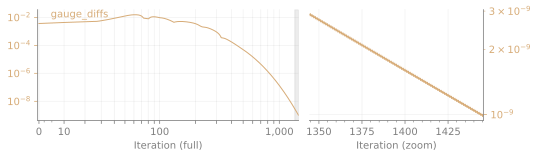

n=1447, D=4, tau=0.01, max|dS|=9.92e-10, energy≈-8.58475:  72%|#######2  | 1447/2000 [01:25<00:32, 17.00it/s]


In [6]:
su.evolve(2000)

In [7]:
psi = su.get_state()

Opptionally use torch + GPU:

In [8]:
def to_backend(x):
    import torch
    return torch.tensor(x, dtype=torch.float32, device="cpu")

psi.apply_to_arrays(to_backend)
ham.apply_to_arrays(to_backend)

Now we choose some parameters for the cluster update:

In [9]:
# imaginary time step
tau = D**-1.5 / 2

# control how the local cluster is generated
# generate generalized loops (gloop) and take their union
mode = "loopunion"
# maximum size for each gloop
max_distance = 5
# how gloop is related to target sites:
# this means each gloop must contain all target sites,
# but the target sites can be dangling (1-degree connected)
grow_from = "alldangle"

# max_distance = 4:
#
#    gloop1      gloop2   union->cluster
#     |  |                        |  |
#    -o--o-                      -o--o-
#     |  |                        |  |
#    -A--B-   +   -A--B-    =    -A--B-
#     |  |         |  |           |  |
#                 -o--o-         -o--o-
#                  |  |           |  |
#
# max_distance = 5:
#
#    gloop 1                 union->cluster
#      |  |                          |  |  |  |
#     -o--o-                        -o--o--o--o-
#      |  |  |                       |  |  |  |
#     -o--A--B-   +    ...      =   -o--A--B--o-
#      |  |  |                       |  |  |  |
#                                   -o--o--o--o-
#    (size 5 with B dangling)        |  |  |  |
#

# no point in less than this for single precision
tol = 1e-7

In [ ]:
cu = ClusterUpdateGen(
    psi,
    ham,
    max_distance=max_distance,
    grow_from=grow_from,
    mode=mode,
    # each gate environment is computed from previous layer
    update="parallel",
    gauge_power=1.0,
    cutoff=0.0,
    second_order_reflect=True,
    gate_opts=dict(
        max_iterations=100,
        tol=tol,
        solver="solve",
        prenormalize=True,
        condition=True,
        enforce_pos=True,
        pos_smudge=tol,
        gauge_smudge=tol,
        init="svd",
    ),
    ordering="sort",
    equilibrate_every=(
        # 0
        # "gate"
        "layer"
        # "sweep"
        # 2
    ),
    equilibrate_opts=dict(
        max_iterations=256,
        tol=tol,
        progbar=False,
    ),
    compute_energy_fn=lambda cu: compute_energy(cu._psi, cu.gauges),
    compute_energy_every=5,
    plot_every=5,
    tol=tol,
    tol_energy_diff=tol / 10,
    keep_best=True,
)

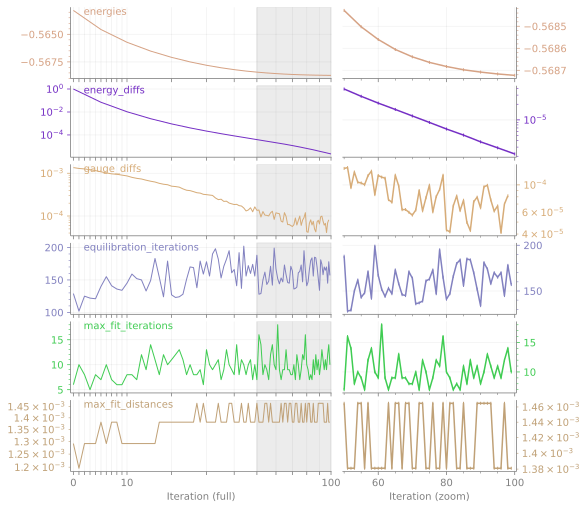

n=100, D=4, tau=0.0625, max|dS|=8.16e-05, energy≈-0.568723: 100%|##########| 100/100 [10:09<00:00,  6.09s/it]


In [12]:
cu.evolve(
    100,
    tau=tau,
    progbar=True,
)